# Cross-lingual Stance Detection: Data Exploration

This notebook explores the Reddit data collected for our cross-lingual stance detection project on climate change discussions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anirb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anirb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the data
data = pd.read_csv('../data/raw/reddit_climate_data_20240831_010210.csv')  # Replace with your actual filename
print(f"Loaded {len(data)} posts")
data.head()

Loaded 3313 posts


,id,title,body,score,num_comments,created_utc,language
0,wu9zny,The r/climatechange Verified User Flair Program,r/climatechange is a community centered around...,40,20,2022-08-21 16:53:23,en
1,1f4vnco,Should we be preparing for Category 6 hurricanes?,NaN,98,72,2024-08-30 09:45:45,en
2,1f53541,Sea Levels Rising,NaN,23,6,2024-08-30 14:58:43,en
3,1f4oduk,Is it possible in this lifetime that we will r...,Sorry if this is doom and gloom but I genuinel...,204,327,2024-08-30 02:22:13,en
4,1f4xr1a,Can someone explain this sea surface temperatu...,From [https://www.realclimate.org/index.php/ar...,15,11,2024-08-30 11:13:52,en


## 1. Basic Statistics

In [3]:
print(data.describe())
print("\nData distribution by language:")
print(data['language'].value_counts())

             score  num_comments
count  3313.000000   3313.000000
mean     66.657712     26.711440
std     152.483128     58.596091
min       0.000000      0.000000
25%       9.000000      2.000000
50%      26.000000      8.000000
75%      65.000000     25.000000
max    3974.000000   1163.000000

Data distribution by language:
language
en    2298
de     998
es      17
Name: count, dtype: int64


## 2. Time Series Analysis

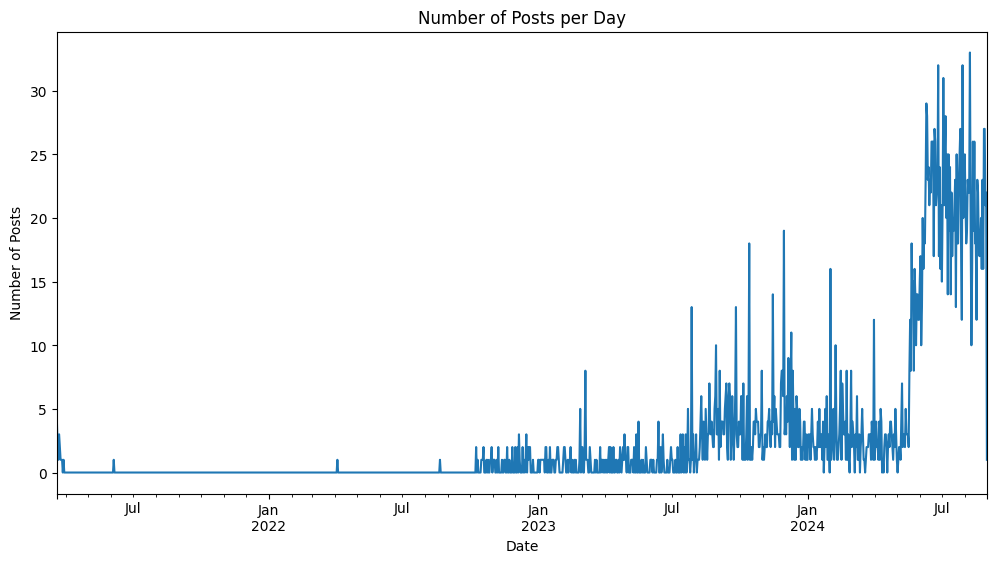

In [4]:
data['created_utc'] = pd.to_datetime(data['created_utc'])
data.set_index('created_utc', inplace=True)
daily_posts = data.resample('D').size()

plt.figure(figsize=(12, 6))
daily_posts.plot()
plt.title('Number of Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## 3. Language-specific Analysis

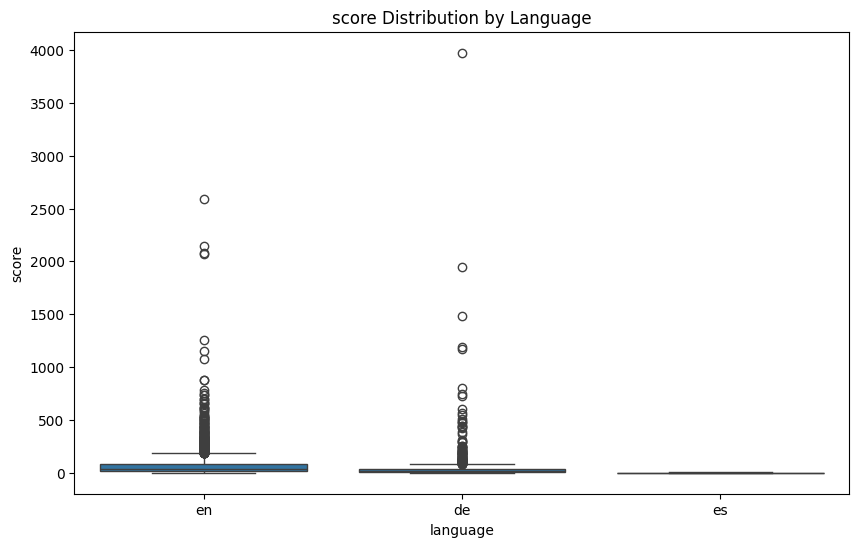

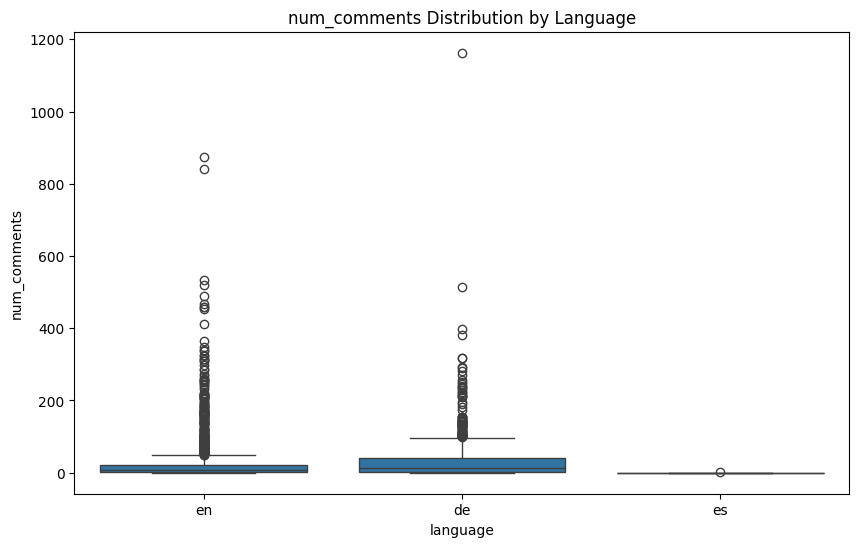

In [5]:
def plot_language_stats(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=column, data=data)
    plt.title(f'{column} Distribution by Language')
    plt.show()

plot_language_stats(data, 'score')
plot_language_stats(data, 'num_comments')

## 4. Content Analysis

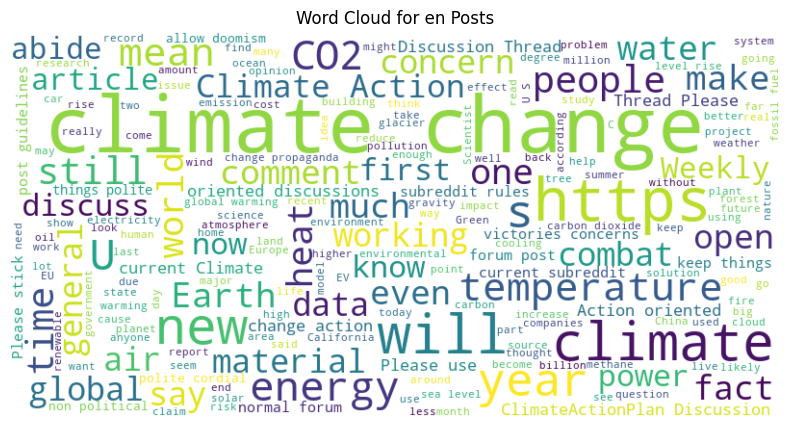

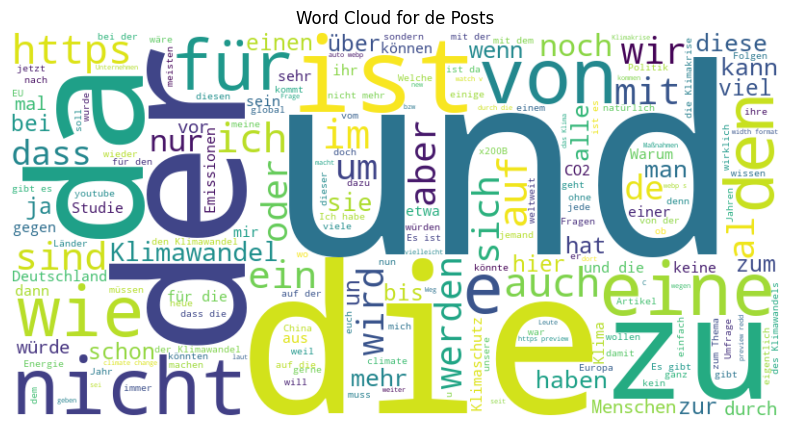

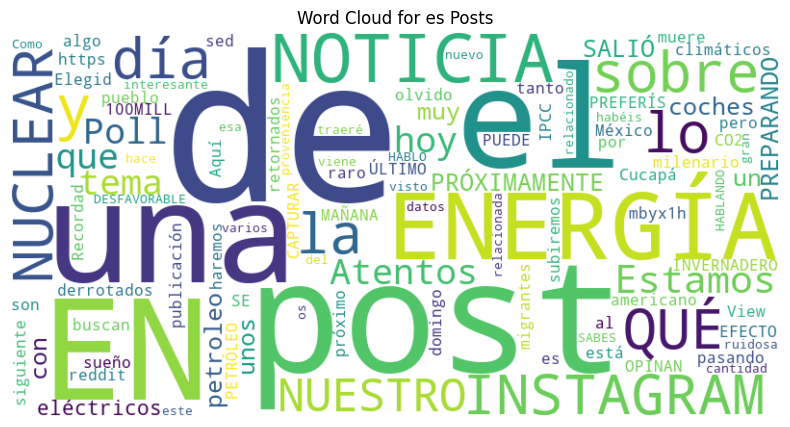

In [8]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each language
for lang in data['language'].unique():
    lang_data = data[data['language'] == lang]
    # Convert to string and replace NaN with empty string
    titles = lang_data['title'].fillna('').astype(str)
    bodies = lang_data['body'].fillna('').astype(str)
    text = ' '.join(titles + ' ' + bodies)
    generate_wordcloud(text, f'Word Cloud for {lang} Posts')

## 5. Preliminary Stance Analysis

Note: This is a very basic approach and should be refined in the preprocessing and modeling stages.

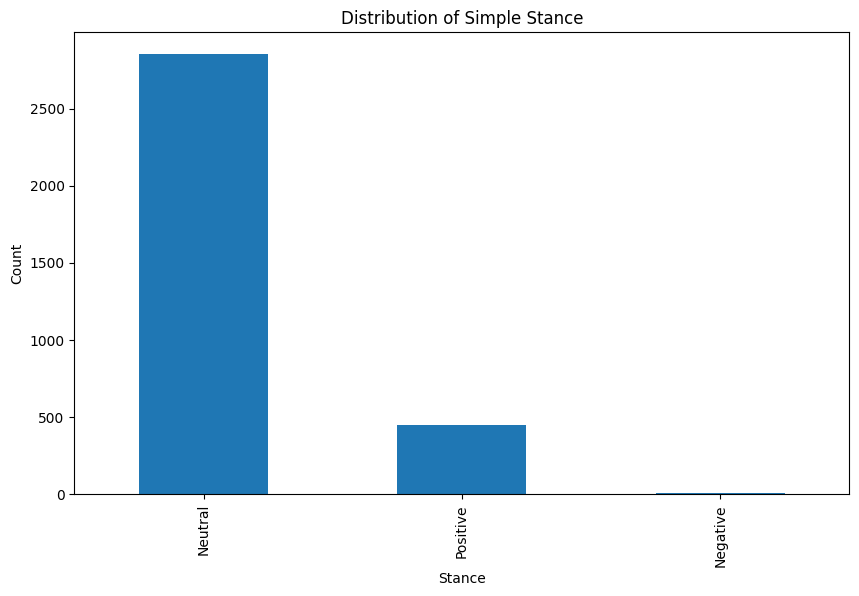

In [9]:
def simple_stance(text):
    positive = ['support', 'agree', 'pro', 'urgent', 'action', 'believe']
    negative = ['hoax', 'fake', 'exaggerated', 'myth', 'scam']
    
    text = text.lower()
    if any(word in text for word in positive):
        return 'Positive'
    elif any(word in text for word in negative):
        return 'Negative'
    else:
        return 'Neutral'

data['simple_stance'] = data['title'].apply(simple_stance)

plt.figure(figsize=(10, 6))
data['simple_stance'].value_counts().plot(kind='bar')
plt.title('Distribution of Simple Stance')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.show()

## 6. Conclusions and Next Steps

Based on this exploratory analysis, we can draw some initial conclusions and outline next steps:

1. Data distribution: 
   - The dataset is heavily imbalanced across languages, with English dominating, followed by German, and very limited Spanish data.
   - This imbalance affects both post frequency and content analysis.

2. Temporal patterns: 
   - Post frequency has increased significantly since early 2023, with occasional spikes.

3. Content differences:
   - English posts focus on climate change, CO2, water, and energy.
   - German posts use more general terms, with some climate-specific vocabulary.
   - Spanish posts seem to focus on news ("NOTICIA"), energy ("ENERGÍA"), and appear to reference social media ("INSTAGRAM"). The limited data makes it harder to draw strong conclusions.

4. Preliminary stance analysis:
   - The simple stance detection shows a strong bias towards neutral stances.
   - Positive stances are more common than negative ones, but both are significantly less frequent than neutral stances.
   - This distribution might indicate limitations in the current stance detection method or reflect the nature of climate change discussions in these forums.

Next steps:
1. Improve stance detection:
   - Develop a more nuanced stance detection method that can better differentiate between neutral, positive, and negative stances.
   - Consider using more advanced NLP techniques or machine learning models trained on climate change discourse.

2. Address data imbalance:
   - Implement techniques like oversampling or undersampling to balance the dataset across languages.
   - Explore options for collecting more Spanish data to improve cross-lingual analysis.

3. Enhance text preprocessing:
   - Implement language-specific stop word removal and stemming/lemmatization.
   - Handle special characters and normalize text across all three languages.

4. Conduct cross-lingual analysis:
   - Utilize multilingual embeddings or translation services to enable direct comparison of content across languages.
   - Investigate how climate change discussions differ across English, German, and Spanish-speaking communities.

5. Temporal trend analysis:
   - Investigate the reasons behind the increase in post frequency from early 2023.
   - Analyze correlations between post spikes and significant climate-related events or news.

6. Refine content analysis:
   - Perform topic modeling separately for each language to identify key themes.
   - Compare topics across languages to understand cultural differences in climate change discourse.

7. Engagement analysis:
   - Analyze the relationship between post scores, number of comments, and detected stance to identify what types of posts generate more engagement.

8. Develop a multilingual stance detection model:
   - Start with a basic model using the preprocessed data.
   - Gradually incorporate more sophisticated NLP techniques, addressing the challenges of multilingual analysis and the current bias towards neutral stances.

9. Investigate social media influence:
   - Given the reference to Instagram in Spanish posts, explore how social media platforms influence climate change discussions across different language communities.

10. Contextualize findings:
    - Research climate policies, public opinions, and media coverage in English, German, and Spanish-speaking countries to provide context for the observed differences in discussions.